In [1]:
# Install required dependencies
!pip install kaggle

# Set up the Kaggle API token (for private datasets)
import os

# Upload your kaggle.json file in the correct directory
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
!cp /kaggle/input/kagglejson/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d felicepollano/watermarked-not-watermarked-images -p /kaggle/working/
!unzip /kaggle/working/watermarked-not-watermarked-images.zip -d /kaggle/working/



cp: cannot stat '/kaggle/input/kagglejson/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/felicepollano/watermarked-not-watermarked-images
License(s): CC-BY-NC-SA-4.0
100%|███████████████████████████████████████▉| 698M/698M [00:31<00:00, 25.1MB/s]
100%|████████████████████████████████████████| 698M/698M [00:31<00:00, 22.9MB/s]
Archive:  /kaggle/working/watermarked-not-watermarked-images.zip
  inflating: /kaggle/working/wm-nowm/.checkpoint  
  inflating: /kaggle/working/wm-nowm/train/no-watermark/IMG_3496bfree.jpg  
  inflating: /kaggle/working/wm-nowm/train/no-watermark/Warsaw-center-free-license-CC0.jpg  
  inflating: /kaggle/working/wm-nowm/train/no-watermark/adler-bird-bird-of-prey-raptor-56865.jpeg  
  inflating: /kaggle/working/wm-nowm/train/no-watermark/africa-animal-big-carnivore-41178.jpeg  
  inflating: /kaggle/working/wm-nowm/train/no-watermark/africa-south-africa-

In [2]:
import os
import cv2

# Define paths
dataset_dir = '/kaggle/working/wm-nowm'

# Function to preprocess images and skip corrupt ones
def preprocess_images(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for category in os.listdir(input_dir):
        category_path = os.path.join(input_dir, category)
        output_category_path = os.path.join(output_dir, category)

        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)

        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            output_img_path = os.path.join(output_category_path, img_name)

            try:
                img = cv2.imread(img_path)
                if img is None:  # Skip invalid images
                    print(f"Skipping corrupt file: {img_name}")
                    continue

                # Save the valid image to the output directory
                cv2.imwrite(output_img_path, img)

            except Exception as e:
                print(f"Error processing {img_name}: {e}")
                continue

# Preprocess training and validation data
train_dir = os.path.join(dataset_dir, 'train')
valid_dir = os.path.join(dataset_dir, 'valid')

preprocessed_train_dir = '/kaggle/working/new/train'
preprocessed_valid_dir = '/kaggle/working/new/valid'

preprocess_images(train_dir, preprocessed_train_dir)
preprocess_images(valid_dir, preprocessed_valid_dir)


Premature end of JPEG file
Premature end of JPEG file


Found 24987 files belonging to 2 classes.
Found 6588 files belonging to 2 classes.
Epoch 1/50
196/196 - 42s - 212ms/step - accuracy: 0.4925 - loss: 1.5285 - val_accuracy: 0.5008 - val_loss: 0.6935 - learning_rate: 0.0010
Epoch 2/50
196/196 - 18s - 91ms/step - accuracy: 0.4951 - loss: 0.6938 - val_accuracy: 0.4997 - val_loss: 0.6939 - learning_rate: 0.0010
Epoch 3/50
196/196 - 18s - 90ms/step - accuracy: 0.4971 - loss: 0.6939 - val_accuracy: 0.4995 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 4/50
196/196 - 18s - 90ms/step - accuracy: 0.4996 - loss: 0.6937 - val_accuracy: 0.5008 - val_loss: 0.6949 - learning_rate: 0.0010
Epoch 5/50
196/196 - 21s - 107ms/step - accuracy: 0.4988 - loss: 0.6937 - val_accuracy: 0.5008 - val_loss: 0.6935 - learning_rate: 5.0000e-04
Epoch 6/50
196/196 - 18s - 91ms/step - accuracy: 0.4971 - loss: 0.6938 - val_accuracy: 0.5008 - val_loss: 0.7009 - learning_rate: 5.0000e-04
Epoch 7/50
196/196 - 18s - 90ms/step - accuracy: 0.4991 - loss: 0.6939 - val_accuracy

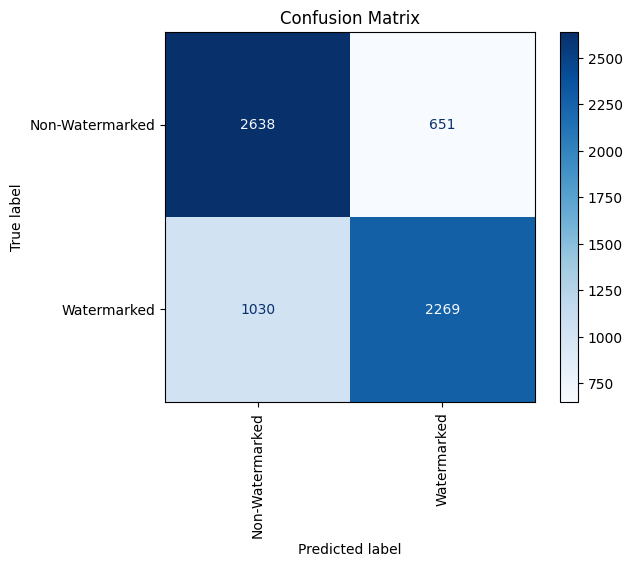

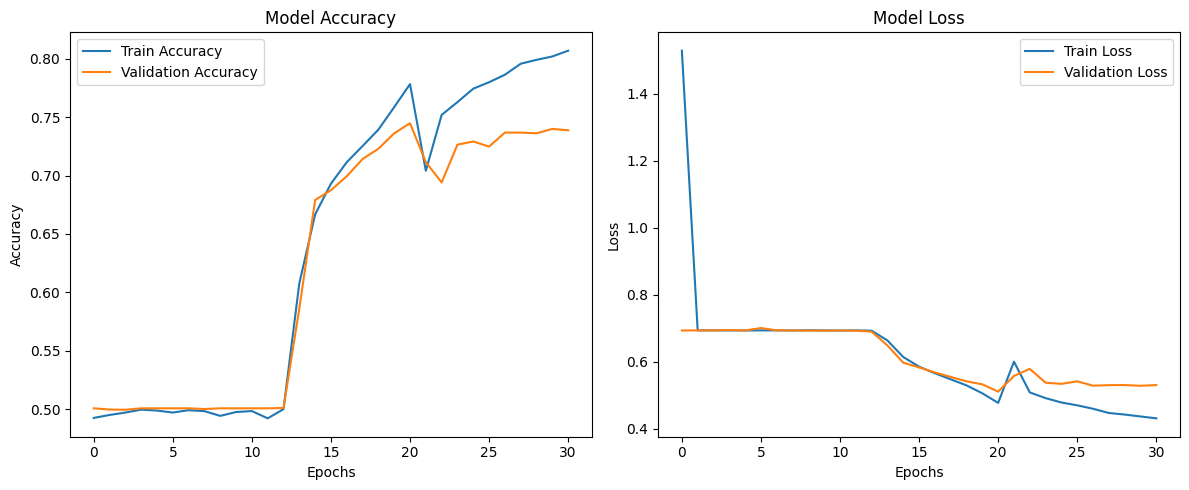

In [16]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from skimage.measure import shannon_entropy

# Enable mixed precision training
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Dataset paths for Kaggle
dataset_dir = "/kaggle/working/new"  # Change this to your actual dataset folder name
train_dir = os.path.join(dataset_dir, 'train')
valid_dir = os.path.join(dataset_dir, 'valid')

# Preprocessing function
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Rescale to range [0, 1]
    return image, label

# Entropy calculation
def calculate_batch_entropy(batch_images):
    """Calculate entropy for a batch of images."""
    batch_entropy = [shannon_entropy((image * 255).numpy().astype(np.uint8)) for image in batch_images]
    return np.array(batch_entropy)

# Load and preprocess dataset
batch_size = 128
img_size = (256, 256)

def load_and_preprocess_dataset(dataset_dir):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_dir,
        image_size=img_size,
        batch_size=batch_size,
        color_mode='grayscale'
    ).map(preprocess_image)
    return dataset

train_dataset = load_and_preprocess_dataset(train_dir)
valid_dataset = load_and_preprocess_dataset(valid_dir)

# Prepare data with entropy
def add_entropy_to_dataset(dataset):
    entropy_features = []
    all_images = []
    all_labels = []

    for images, labels in dataset:
        entropies = calculate_batch_entropy(images)
        entropy_features.extend(entropies)
        all_images.extend(images.numpy())
        all_labels.extend(labels.numpy())

    # Normalize entropy
    entropy_features = np.array(entropy_features)
    entropy_features = (entropy_features - np.min(entropy_features)) / (np.max(entropy_features) - np.min(entropy_features))

    return np.array(all_images), entropy_features, np.array(all_labels)

train_images, train_entropy, train_labels = add_entropy_to_dataset(train_dataset)
valid_images, valid_entropy, valid_labels = add_entropy_to_dataset(valid_dataset)

# Define the combined CNN model
input_image = Input(shape=(256, 256, 1), name="image_input")
input_entropy = Input(shape=(1,), name="entropy_input")

x = Conv2D(32, (3, 3), activation='elu')(input_image)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='elu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='elu')(x)

# Combine CNN output with entropy input
combined = Concatenate()([x, input_entropy])
output = Dense(1, activation='sigmoid', dtype='float32')(combined)

model = Model(inputs=[input_image, input_entropy], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_with_entropy.keras', save_best_only=True)

# Train the model
history = model.fit(
    [train_images, train_entropy], train_labels,
    validation_data=([valid_images, valid_entropy], valid_labels),
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint],
    verbose=2
)

# Evaluate the model
loss, accuracy = model.evaluate([valid_images, valid_entropy], valid_labels, verbose=2)
print(f"Validation Accuracy: {accuracy:.2f}")

# Predict and calculate metrics
y_pred_probs = model.predict([valid_images, valid_entropy])
y_pred = (y_pred_probs > 0.5).astype(int)

print("Classification Report:")
print(classification_report(valid_labels, y_pred, target_names=['Non-Watermarked', 'Watermarked']))

# Confusion matrix
conf_matrix = confusion_matrix(valid_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non-Watermarked', 'Watermarked'])
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from skimage.measure import shannon_entropy

# Enable mixed precision training
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Dataset paths
dataset_dir = "/kaggle/working/new"  # Update this to match your Kaggle dataset folder
train_dir = os.path.join(dataset_dir, 'train')
valid_dir = os.path.join(dataset_dir, 'valid')

# Preprocessing function
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Rescale to range [0, 1]
    return image, label

# Entropy calculation for a single image
def calculate_image_entropy(image):
    """Calculate entropy for a single image."""
    return shannon_entropy((image * 255).numpy().astype(np.uint8))

# Load and preprocess dataset
batch_size = 128
img_size = (256, 256)

def load_and_preprocess_dataset(dataset_dir):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_dir,
        image_size=img_size,
        batch_size=batch_size,
        color_mode='grayscale'
    ).map(preprocess_image)
    return dataset

train_dataset = load_and_preprocess_dataset(train_dir)
valid_dataset = load_and_preprocess_dataset(valid_dir)

# Prepare data with entropy
def add_entropy_to_dataset(dataset):
    entropy_features = []
    all_images = []
    all_labels = []

    for images, labels in dataset:
        for image in images:
            entropy = calculate_image_entropy(image)
            entropy_features.append(entropy)
            all_images.append(image.numpy())
        all_labels.extend(labels.numpy())

    # Normalize entropy
    entropy_features = np.array(entropy_features)
    entropy_features = (entropy_features - np.min(entropy_features)) / (np.max(entropy_features) - np.min(entropy_features))

    return np.array(all_images), entropy_features, np.array(all_labels)

train_images, train_entropy, train_labels = add_entropy_to_dataset(train_dataset)
valid_images, valid_entropy, valid_labels = add_entropy_to_dataset(valid_dataset)

# Define the combined CNN model
input_image = Input(shape=(256, 256, 1), name="image_input")
input_entropy = Input(shape=(1,), name="entropy_input")

x = Conv2D(32, (3, 3), activation='elu')(input_image)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='elu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='elu')(x)

# Combine CNN output with entropy input
combined = Concatenate()([x, input_entropy])
output = Dense(1, activation='sigmoid', dtype='float32')(combined)

model = Model(inputs=[input_image, input_entropy], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
model_checkpoint = ModelCheckpoint('/kaggle/working/best_model_with_entropy.keras', save_best_only=True)

# Train the model
history = model.fit(
    [train_images, train_entropy], train_labels,
    validation_data=([valid_images, valid_entropy], valid_labels),
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint],
    verbose=2
)

# Evaluate the model
loss, accuracy = model.evaluate([valid_images, valid_entropy], valid_labels, verbose=2)
print(f"Validation Accuracy: {accuracy:.2f}")

# Predict and calculate metrics
y_pred_probs = model.predict([valid_images, valid_entropy])
y_pred = (y_pred_probs > 0.5).astype(int)

print("Classification Report:")
print(classification_report(valid_labels, y_pred, target_names=['Non-Watermarked', 'Watermarked']))

# Confusion matrix
conf_matrix = confusion_matrix(valid_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non-Watermarked', 'Watermarked'])
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Found 24987 files belonging to 2 classes.
Found 6588 files belonging to 2 classes.


Found 24987 files belonging to 2 classes.
Found 6588 files belonging to 2 classes.
Epoch 1/20


I0000 00:00:1733654904.200427    3593 service.cc:145] XLA service 0x7eefdc004b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733654904.200511    3593 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733654908.153646    3593 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


781/781 - 18s - 22ms/step - accuracy: 0.6338 - loss: 0.6646 - val_accuracy: 0.7039 - val_loss: 0.5587 - learning_rate: 0.0010
Epoch 2/20
781/781 - 7s - 10ms/step - accuracy: 0.7281 - loss: 0.5303 - val_accuracy: 0.7442 - val_loss: 0.5100 - learning_rate: 0.0010
Epoch 3/20
781/781 - 7s - 9ms/step - accuracy: 0.7808 - loss: 0.4573 - val_accuracy: 0.7591 - val_loss: 0.4910 - learning_rate: 0.0010
Epoch 4/20
781/781 - 7s - 10ms/step - accuracy: 0.8212 - loss: 0.3895 - val_accuracy: 0.7773 - val_loss: 0.4846 - learning_rate: 0.0010
Epoch 5/20
781/781 - 7s - 9ms/step - accuracy: 0.8451 - loss: 0.3489 - val_accuracy: 0.7637 - val_loss: 0.5350 - learning_rate: 0.0010
Epoch 6/20
781/781 - 7s - 9ms/step - accuracy: 0.7778 - loss: 0.4405 - val_accuracy: 0.7690 - val_loss: 0.5487 - learning_rate: 0.0010
Epoch 7/20
781/781 - 7s - 9ms/step - accuracy: 0.8952 - loss: 0.2455 - val_accuracy: 0.7688 - val_loss: 0.5617 - learning_rate: 0.0010
Epoch 8/20
781/781 - 7s - 9ms/step - accuracy: 0.9335 - loss: 

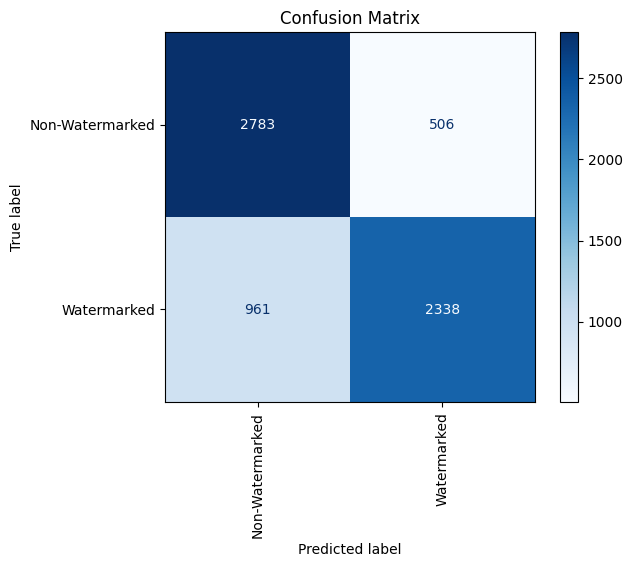

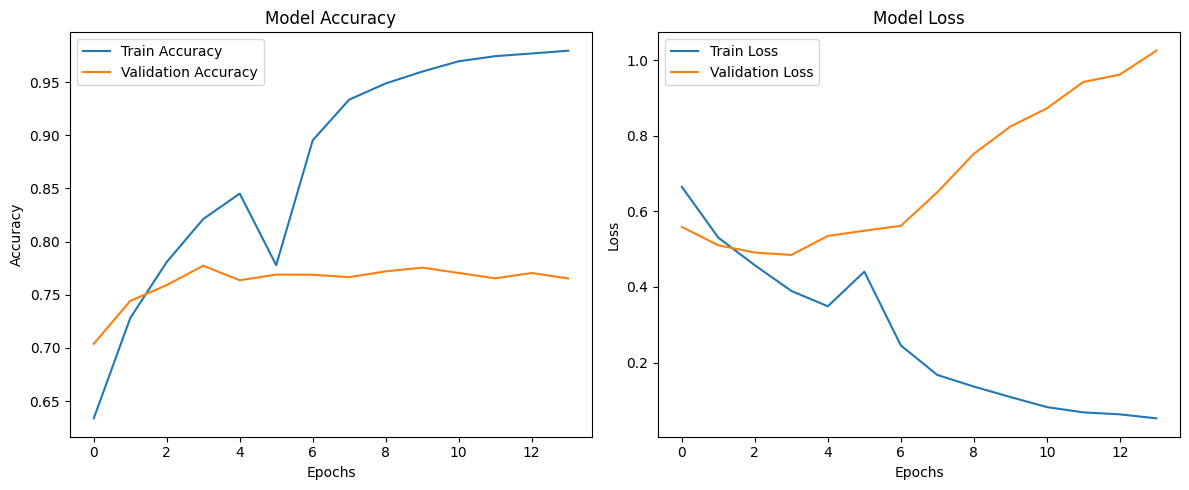

In [2]:
import os  
import tensorflow as tf  
from tensorflow.keras.models import Model  
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate  
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint  
import matplotlib.pyplot as plt  
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay  
import numpy as np  
from skimage.measure import shannon_entropy  

# Enable mixed precision training  
from tensorflow.keras import mixed_precision  
policy = mixed_precision.Policy('mixed_float16')  
mixed_precision.set_global_policy(policy)  

# Dataset paths  
dataset_dir = "/kaggle/working/new"  # Update this to match your Kaggle dataset folder  
train_dir = os.path.join(dataset_dir, 'train')  
valid_dir = os.path.join(dataset_dir, 'valid')  

# Preprocessing function  
def preprocess_image(image, label):  
    image = tf.cast(image, tf.float32) / 255.0  # Rescale to range [0, 1]  
    return image, label  

# Entropy calculation for a single image  
def calculate_image_entropy(image):  
    """Calculate entropy for a single image."""  
    return shannon_entropy((image * 255).numpy().astype(np.uint8))  

# Load and preprocess dataset using tf.data API  
batch_size = 32  # Reduced to save memory  
img_size = (128, 128)  # Reduced image size  

def get_data_generator(dataset_dir):  
    dataset = tf.keras.preprocessing.image_dataset_from_directory(  
        dataset_dir,  
        image_size=img_size,  
        batch_size=batch_size,  
        color_mode='grayscale',  
        shuffle=True  
    ).map(preprocess_image).prefetch(tf.data.AUTOTUNE)  # Prefetch for performance  
    return dataset  

train_dataset = get_data_generator(train_dir)  
valid_dataset = get_data_generator(valid_dir)  

# Prepare data with entropy  
def add_entropy_to_dataset(dataset):  
    entropy_features = []  
    all_images = []  
    all_labels = []  

    for images, labels in dataset:  
        for image in images:  
            entropy = calculate_image_entropy(image)  
            entropy_features.append(entropy)  
            all_images.append(image.numpy())  
        all_labels.extend(labels.numpy())  

    # Normalize entropy  
    entropy_features = np.array(entropy_features)  
    entropy_features = (entropy_features - np.min(entropy_features)) / (np.max(entropy_features) - np.min(entropy_features))  

    return np.array(all_images), entropy_features, np.array(all_labels)  

# Extract entropy for both train and validation datasets  
train_images, train_entropy, train_labels = add_entropy_to_dataset(train_dataset)  
valid_images, valid_entropy, valid_labels = add_entropy_to_dataset(valid_dataset)  

# Define the combined CNN model  
input_image = Input(shape=(128, 128, 1), name="image_input")  
input_entropy = Input(shape=(1,), name="entropy_input")  

x = Conv2D(32, (3, 3), activation='elu')(input_image)  
x = MaxPooling2D((2, 2))(x)  
x = Conv2D(64, (3, 3), activation='elu')(x)  
x = MaxPooling2D((2, 2))(x)  
x = Flatten()(x)  
x = Dropout(0.3)(x)  
x = Dense(128, activation='elu')(x)  

# Combine CNN output with entropy input  
combined = Concatenate()([x, input_entropy])  
output = Dense(1, activation='sigmoid', dtype='float32')(combined)  

model = Model(inputs=[input_image, input_entropy], outputs=output)  
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  

# Callbacks  
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)  
model_checkpoint = ModelCheckpoint('/kaggle/working/best_model_with_entropy.keras', save_best_only=True)  

# Train the model  
history = model.fit(  
    [train_images, train_entropy], train_labels,  
    validation_data=([valid_images, valid_entropy], valid_labels),  
    epochs=20,  # Reduced number of epochs for faster testing  
    callbacks=[early_stopping, lr_scheduler, model_checkpoint],  
    verbose=2  
)  

# Evaluate the model  
loss, accuracy = model.evaluate([valid_images, valid_entropy], valid_labels, verbose=2)  
print(f"Validation Accuracy: {accuracy:.2f}")  

# Predict and calculate metrics  
y_pred_probs = model.predict([valid_images, valid_entropy])  
y_pred = (y_pred_probs > 0.5).astype(int)  

print("Classification Report:")  
print(classification_report(valid_labels, y_pred, target_names=['Non-Watermarked', 'Watermarked']))  

# Confusion matrix  
conf_matrix = confusion_matrix(valid_labels, y_pred)  
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non-Watermarked', 'Watermarked'])  
disp.plot(cmap='Blues', xticks_rotation='vertical')  
plt.title('Confusion Matrix')  
plt.show()  

# Plot training history  
plt.figure(figsize=(12, 5))  

# Accuracy plot  
plt.subplot(1, 2, 1)  
plt.plot(history.history['accuracy'], label='Train Accuracy')  
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  
plt.title('Model Accuracy')  
plt.xlabel('Epochs')  
plt.ylabel('Accuracy')  
plt.legend()  

# Loss plot  
plt.subplot(1, 2, 2)  
plt.plot(history.history['loss'], label='Train Loss')  
plt.plot(history.history['val_loss'], label='Validation Loss')  
plt.title('Model Loss')  
plt.xlabel('Epochs')  
plt.ylabel('Loss')  
plt.legend()  

plt.tight_layout()  
plt.show()

Found 24987 files belonging to 2 classes.
Found 6588 files belonging to 2 classes.
Epoch 1/50
781/781 - 15s - 19ms/step - accuracy: 0.5360 - loss: 0.7180 - val_accuracy: 0.6595 - val_loss: 0.6185 - learning_rate: 0.0010
Epoch 2/50
781/781 - 7s - 10ms/step - accuracy: 0.6886 - loss: 0.5793 - val_accuracy: 0.7146 - val_loss: 0.5473 - learning_rate: 0.0010
Epoch 3/50
781/781 - 7s - 9ms/step - accuracy: 0.7343 - loss: 0.5291 - val_accuracy: 0.7265 - val_loss: 0.6227 - learning_rate: 0.0010
Epoch 4/50
781/781 - 7s - 10ms/step - accuracy: 0.7688 - loss: 0.4798 - val_accuracy: 0.7646 - val_loss: 0.4834 - learning_rate: 0.0010
Epoch 5/50
781/781 - 7s - 10ms/step - accuracy: 0.8040 - loss: 0.4230 - val_accuracy: 0.7734 - val_loss: 0.4751 - learning_rate: 0.0010
Epoch 6/50
781/781 - 7s - 9ms/step - accuracy: 0.8372 - loss: 0.3638 - val_accuracy: 0.7744 - val_loss: 0.4865 - learning_rate: 0.0010
Epoch 7/50
781/781 - 7s - 9ms/step - accuracy: 0.8723 - loss: 0.3007 - val_accuracy: 0.7729 - val_loss

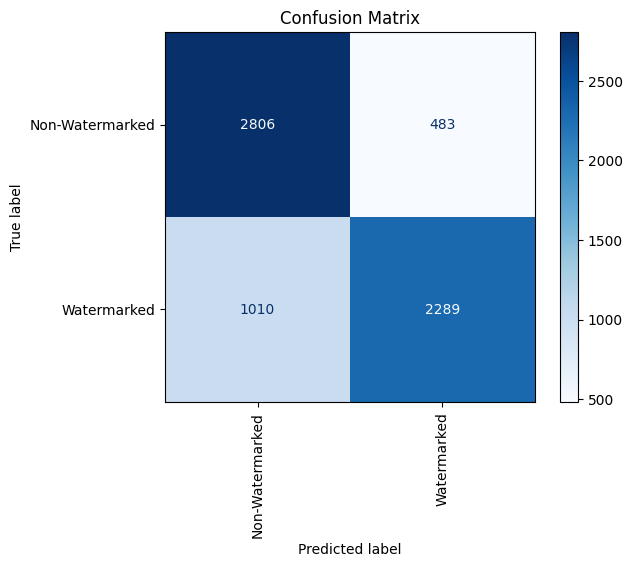

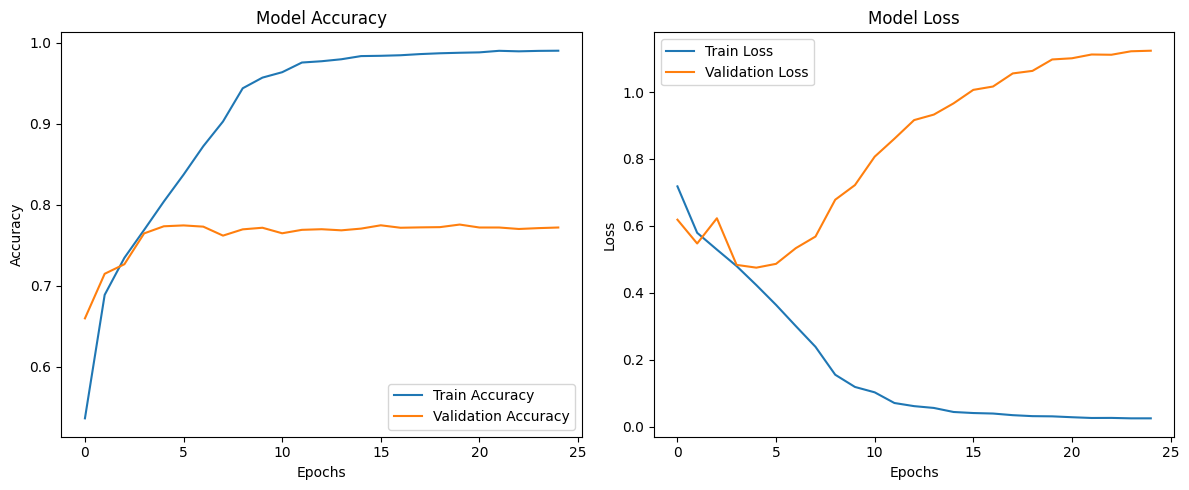

In [3]:
import os  
import tensorflow as tf  
from tensorflow.keras.models import Model  
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate  
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint  
import matplotlib.pyplot as plt  
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay  
import numpy as np  
from skimage.measure import shannon_entropy  

# Enable mixed precision training  
from tensorflow.keras import mixed_precision  
policy = mixed_precision.Policy('mixed_float16')  
mixed_precision.set_global_policy(policy)  

# Dataset paths  
dataset_dir = "/kaggle/working/new"  # Update this to match your Kaggle dataset folder  
train_dir = os.path.join(dataset_dir, 'train')  
valid_dir = os.path.join(dataset_dir, 'valid')  

# Preprocessing function  
def preprocess_image(image, label):  
    image = tf.cast(image, tf.float32) / 255.0  # Rescale to range [0, 1]  
    return image, label  

# Entropy calculation for a single image  
def calculate_image_entropy(image):  
    """Calculate entropy for a single image."""  
    return shannon_entropy((image * 255).numpy().astype(np.uint8))  

# Load and preprocess dataset using tf.data API  
batch_size = 32  # Reduced to save memory  
img_size = (128, 128)  # Reduced image size  

def get_data_generator(dataset_dir):  
    dataset = tf.keras.preprocessing.image_dataset_from_directory(  
        dataset_dir,  
        image_size=img_size,  
        batch_size=batch_size,  
        color_mode='grayscale',  
        shuffle=True  
    ).map(preprocess_image).prefetch(tf.data.AUTOTUNE)  # Prefetch for performance  
    return dataset  

train_dataset = get_data_generator(train_dir)  
valid_dataset = get_data_generator(valid_dir)  

# Prepare data with entropy  
def add_entropy_to_dataset(dataset):  
    entropy_features = []  
    all_images = []  
    all_labels = []  

    for images, labels in dataset:  
        for image in images:  
            entropy = calculate_image_entropy(image)  
            entropy_features.append(entropy)  
            all_images.append(image.numpy())  
        all_labels.extend(labels.numpy())  

    # Normalize entropy  
    entropy_features = np.array(entropy_features)  
    entropy_features = (entropy_features - np.min(entropy_features)) / (np.max(entropy_features) - np.min(entropy_features))  

    return np.array(all_images), entropy_features, np.array(all_labels)  

# Extract entropy for both train and validation datasets  
train_images, train_entropy, train_labels = add_entropy_to_dataset(train_dataset)  
valid_images, valid_entropy, valid_labels = add_entropy_to_dataset(valid_dataset)  

# Ensure entropy features have the right shape for input (1D)  
train_entropy = train_entropy.reshape(-1, 1)  
valid_entropy = valid_entropy.reshape(-1, 1)  

# Define the combined CNN model  
input_image = Input(shape=(128, 128, 1), name="image_input")  
input_entropy = Input(shape=(1,), name="entropy_input")  

x = Conv2D(32, (3, 3), activation='elu')(input_image)  
x = MaxPooling2D((2, 2))(x)  
x = Conv2D(64, (3, 3), activation='elu')(x)  
x = MaxPooling2D((2, 2))(x)  
x = Flatten()(x)  
x = Dropout(0.3)(x)  
x = Dense(128, activation='elu')(x)  

# Combine CNN output with entropy input  
combined = Concatenate()([x, input_entropy])  
output = Dense(1, activation='sigmoid', dtype='float32')(combined)  

model = Model(inputs=[input_image, input_entropy], outputs=output)  
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  

# Callbacks  
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)  
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)  
model_checkpoint = ModelCheckpoint('/kaggle/working/best_model_with_entropy.keras', save_best_only=True)  

# Train the model  
history = model.fit(  
    [train_images, train_entropy],  
    train_labels,  
    validation_data=([valid_images, valid_entropy], valid_labels),  
    epochs=50,  # Reduced number of epochs for faster testing  
    callbacks=[early_stopping, lr_scheduler, model_checkpoint],  
    verbose=2  
)  

# Evaluate the model  
loss, accuracy = model.evaluate([valid_images, valid_entropy], valid_labels, verbose=2)  
print(f"Validation Accuracy: {accuracy:.2f}")  

# Predict and calculate metrics  
y_pred_probs = model.predict([valid_images, valid_entropy])  
y_pred = (y_pred_probs > 0.5).astype(int)  

print("Classification Report:")  
print(classification_report(valid_labels, y_pred, target_names=['Non-Watermarked', 'Watermarked']))  

# Confusion matrix  
conf_matrix = confusion_matrix(valid_labels, y_pred)  
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non-Watermarked', 'Watermarked'])  
disp.plot(cmap='Blues', xticks_rotation='vertical')  
plt.title('Confusion Matrix')  
plt.show()  

# Plot training history  
plt.figure(figsize=(12, 5))  

# Accuracy plot  
plt.subplot(1, 2, 1)  
plt.plot(history.history['accuracy'], label='Train Accuracy')  
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  
plt.title('Model Accuracy')  
plt.xlabel('Epochs')  
plt.ylabel('Accuracy')  
plt.legend()  

# Loss plot  
plt.subplot(1, 2, 2)  
plt.plot(history.history['loss'], label='Train Loss')  
plt.plot(history.history['val_loss'], label='Validation Loss')  
plt.title('Model Loss')  
plt.xlabel('Epochs')  
plt.ylabel('Loss')  
plt.legend()  

plt.tight_layout()  
plt.show()